# Fragment library analysis

## Aim of this notebook

This notebook contains the code that was used to calculate most of the statistics as well as to generate the respective plots shown in the manuscript. 

## Table of contents

1. Fragment library
2. Original ligands
3. Ligand occupancy across subpockets
4. Subpocket connectivity across subpockets
5. Fragment occurrence per subpocket
6. Fragment properties per subpocket
7. Fragment similarity per subpocket
8. Fragment promiscuity
9. Draw ligand and fragments for GitHub README figure

In [1]:
%load_ext autoreload
%autoreload 2

Install the Table of Contents extension for JupyterLab for easy navigation through this notebook: https://github.com/jupyterlab/jupyterlab-toc

[Note this was already recommended in the README, so you might want to ommit the next line of code]

In [2]:
from collections import Counter
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools

from utils import *

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
PATH_DATA = Path('.') / '..' / 'data'

## 1. Fragment library

### Load fragment library

Let's load the fragment library (in different formats for different kind of analysis later on):

- `fragment_library`: Dictionary of fragments (values as DataFrame) by subpockets (keys).
- `fragment_library_concat`: All fragments in one DataFrame.
- `fragment_library_concat_wo_x`: All fragments except fragments from pool X in one DataFrame.

**Load fragment library's subpocket pools: `fragment_library`**

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

The following data is linked to each fragment:

- `ROMol`, `ROMol_dummy`, and `ROMol_original`: RDKit molecules for the 2D representation of the fragment without and with dummy atoms as well as for the 3D representation of the fragment as described in the SDF file from which the data is loaded.
- `kinase`, `family`, and `group`: *Kinase* name, *family* and *group* of the kinase that the ligand (from which the fragment originates) was co-crystallized with
- `complex_pdb`, `ligand_pdb`, `alt`, and `chain`: *PDB complex* and *ligand ID*, *alternate model* and *chain* for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- `atom_subpockets`: Subpocket assignment for each of the fragment's atoms
- `atom_environments`: BRICS environment IDs for each of the fragment's atoms
- `smiles` and `smiles_dummy`: SMILES for the fragment without and with dummy atoms
- `subpocket`: Subpocket assignment for the fragment

In [5]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Index(['ROMol', 'ROMol_dummy', 'ROMol_original', 'kinase', 'family', 'group',
       'complex_pdb', 'ligand_pdb', 'alt', 'chain', 'atom_subpockets',
       'atom_environments', 'smiles', 'smiles_dummy', 'subpocket'],
      dtype='object')
Example fragments for subpocket AP:


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

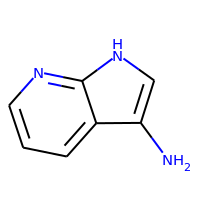
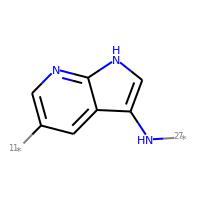
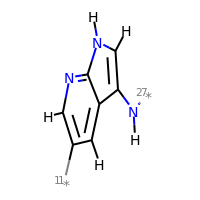
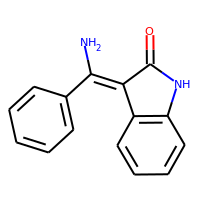
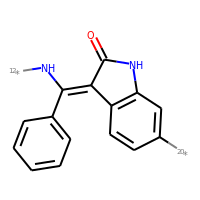
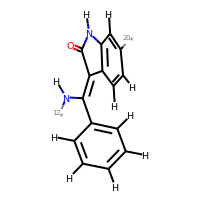

In [6]:
# Output info in library
print(fragment_library.keys())
print(fragment_library['AP'].columns)
print(f'Example fragments for subpocket AP:')
fragment_library['AP'].head(2)

**Load fragment library in one DataFrame: `fragment_library_concat` and `fragment_library_concat_wo_x`**

In [7]:
fragment_library_concat = fragment_library_concat = pd.concat(fragment_library.values())

,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

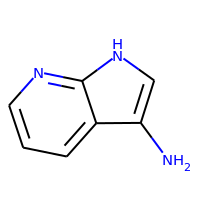
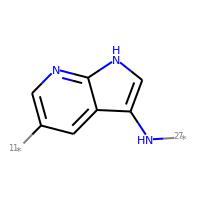
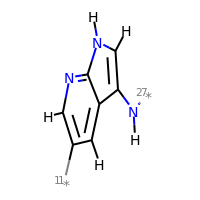
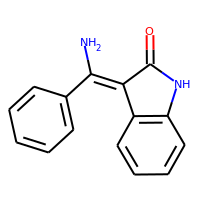
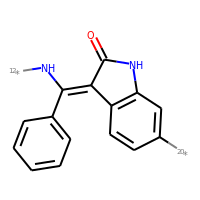
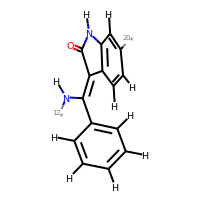

In [8]:
fragment_library_concat.head(2)

`fragment_library_concat_wo_x` is `fragment_library_concat` without fragments from pool X.

In [9]:
# Remove pool X
fragment_library_concat_wo_x = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()

### Get fragment library overview

How many fragments (with and without pool X) do we have?

In [10]:
# Number of fragments in all fragment subpocket pools
n_fragments = fragment_library_concat.shape[0]

# Number of fragments in all fragment subpocket pools except pool X
n_fragments_wo_x = fragment_library_concat_wo_x.shape[0]

print(f'Number of fragments in library: {n_fragments}')
print(f'Number of fragments in library without pool X: {n_fragments_wo_x}')

Number of fragments in library: 7486
Number of fragments in library without pool X: 7201


From how many original ligands do these come from?

In [11]:
# Deduplicate these strings in order to get the number of ligands from which the fragments originate
n_original_ligands = fragment_library_concat.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

print(f'Number of original ligands (from which fragments originate): {n_original_ligands}')

Number of original ligands (from which fragments originate): 2553


## 2. Original ligands

Load original ligands from file. 

Fragment library is grouped by ligand, each ligand is linked to the following data:

- PDB complex and ligand ID, alternate model, chain, and aC-helix conformation for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- Kinase name, family, and group of the kinase the ligand (from which the fragment originates) was co-crystallized with
- Subpockets occupied by the ligand
- Ligand RDKit molecule (remote KLIFS access) and SMILES (generated from RDKit molecule)

Check out notebook `original_ligands.ipynb` for details on data construction.

(2553, 12)


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,ROMol
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...,
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...,

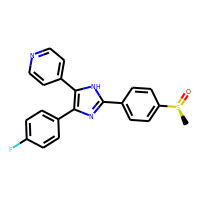
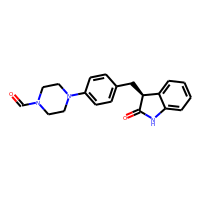

In [12]:
original_ligands = pd.read_json(PATH_DATA / 'fragment_library' / 'original_ligands.json')
PandasTools.AddMoleculeColumnToFrame(original_ligands, 'smiles')

print(original_ligands.shape)
original_ligands.head(2)

## 3. Ligand occupancy across subpockets

Calculate the number of subpockets a ligand is occupying. 

(Here, it is not of interest how often a subpocket is occupied by a ligand. Thus, we keep only one entry per ligand and subpocket.)

In [13]:
n_subpockets_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).first().reset_index().groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size()

In [14]:
n_subpockets_per_ligand_distribution = pd.concat(
    [
        n_subpockets_per_ligand.value_counts().sort_index().rename('ligand_count'),
        n_subpockets_per_ligand.value_counts(normalize=True).sort_index().rename('ligand_frequency')*100
    ],
    axis=1
)

In [15]:
print('Number of subpockets per ligand (distribution):')
n_subpockets_per_ligand_distribution

Number of subpockets per ligand (distribution):


,ligand_count,ligand_frequency
1,127,4.974540
2,719,28.162946
3,1350,52.878966
4,327,12.808461
5,29,1.135919
6,1,0.039170


**Creates Figure 3.A in manuscript**

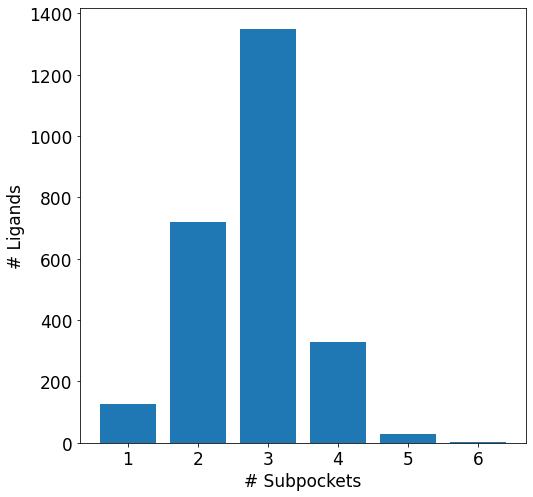

In [16]:
plot_n_subpockets(n_subpockets_per_ligand_distribution)

### Examples for a few special cases of ligands/fragments discussed in the manuscript

#### Ligands occupying 6 subpockets

Could equally be adapted to get samples for ligands occupying less subpockets.

In [17]:
ligand_of_interest_six = n_subpockets_per_ligand[n_subpockets_per_ligand == 6].reset_index()
ligand_of_interest_six

,kinase,complex_pdb,ligand_pdb,0
0,ALK,4fnz,NZF,6


**Creates Figure S1.A in supporting information**

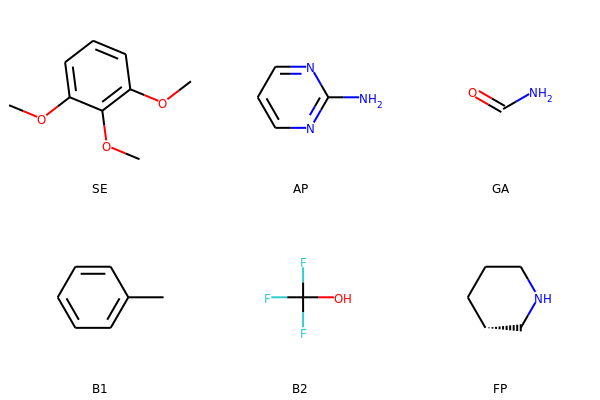

In [18]:
image_six_subpockets = draw_fragmented_ligand(
    fragment_library, 
    ligand_of_interest_six.complex_pdb.values[0], 
    ligand_of_interest_six.ligand_pdb.values[0],
    mols_per_row=3
)
image_six_subpockets.save(f'figures/extreme_subpockets_six_fragments.png')
image_six_subpockets

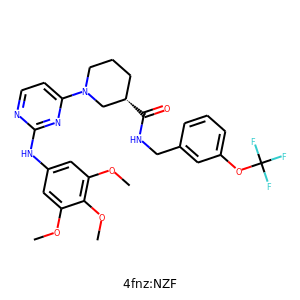

In [19]:
image_ligand_from_pdb_ids = draw_ligands_from_pdb_ids('4fnz', 'NZF', sub_img_size=(300,300))
image_ligand_from_pdb_ids.save(f'figures/extreme_subpockets_six_ligand.png')
image_ligand_from_pdb_ids

#### Unfragmented ligands

Collect all ligands that only cover one subpocket.

In [20]:
ligand_of_interest_one = n_subpockets_per_ligand[n_subpockets_per_ligand == 1].reset_index()

In [21]:
# Get info for those ligands
unfragmented_ligands = []

for index, row in ligand_of_interest_one.iterrows():
    
    unfragmented_ligands.append(
        get_fragmented_ligand(
            fragment_library, 
            row.complex_pdb, 
            row.ligand_pdb
        )
    )
    
unfragmented_ligands = pd.concat(unfragmented_ligands)

In [22]:
unfragmented_ligands.shape

(127, 15)

In [23]:
n_heavy_atoms_unfragmented_fragments = unfragmented_ligands.apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()
n_heavy_atoms_ap_fragments = fragment_library['AP'].apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()

print(f'Mean number of heavy atoms in unfragmented ligands: {n_heavy_atoms_unfragmented_fragments}')
print(f'Mean number of heavy atoms in AP fragments: {n_heavy_atoms_ap_fragments}')

Mean number of heavy atoms in unfragmented ligands: 15.346456692913385
Mean number of heavy atoms in AP fragments: 11.005466614603671


/home/dominique/anaconda2/envs/kinfraglib/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


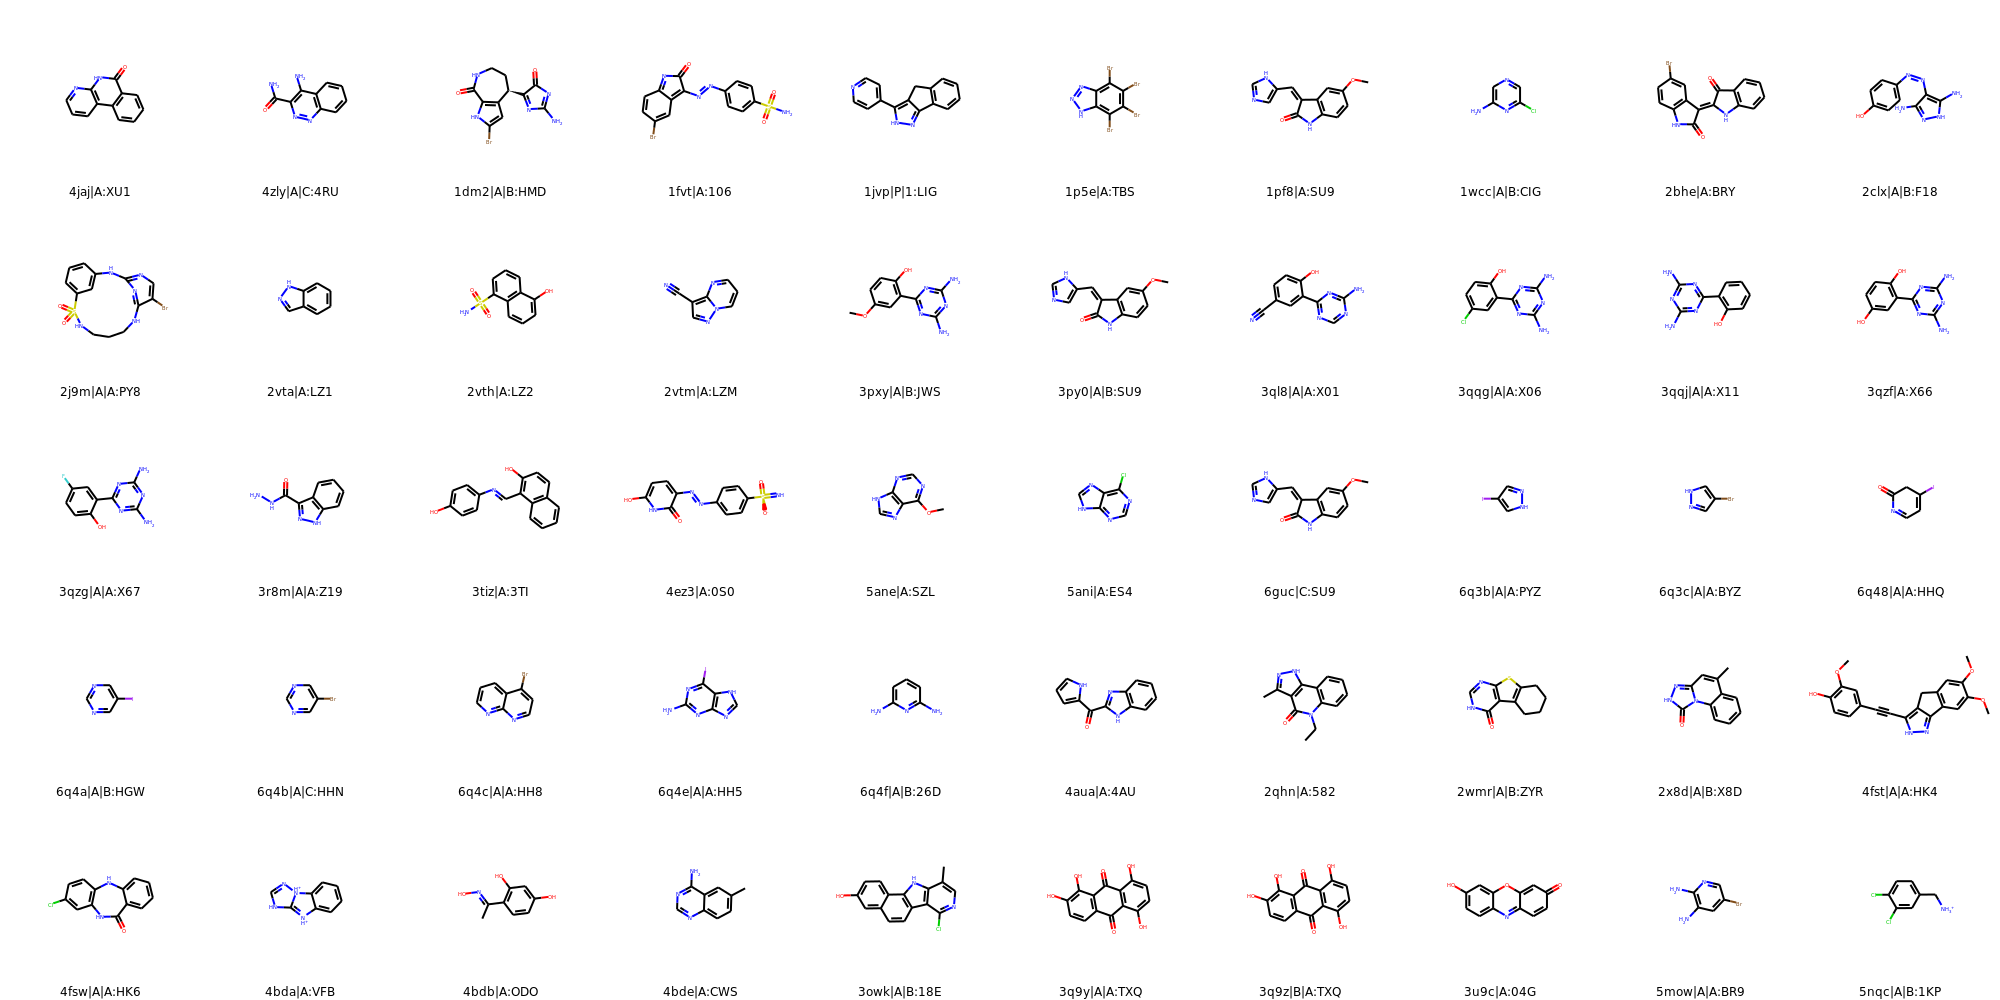

In [24]:
# Draw and save those ligands
image_unfragmented = draw_fragments(unfragmented_ligands, mols_per_row=10)
image_unfragmented.save(f'figures/extreme_subpockets_one.png')
image_unfragmented

#### Are unfragmented ligands substructures of other original ligands?

In [25]:
# Takes 1-2 minutes
unfragmented_in_original_ligands = []
unfragmented_as_substructure_in_original_ligands = []

for i, unfragmented_ligand in unfragmented_ligands.iterrows():
    for j, original_ligand in original_ligands.iterrows():
        
        template = original_ligand.ROMol
        pattern = unfragmented_ligand.ROMol
        match = template.HasSubstructMatch(pattern)

        if match:
            substructure = template.GetSubstructMatch(pattern)

            # Unfragmented ligand is the full original ligand
            if len(substructure) == template.GetNumAtoms():
                unfragmented_in_original_ligands.append([i, pattern, j, template, substructure])
            
            # Unfragmented ligand is substructure of original ligand
            else:
                unfragmented_as_substructure_in_original_ligands.append([i, pattern, j, template, substructure])
                
unfragmented_in_original_ligands = pd.DataFrame(
    unfragmented_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

unfragmented_as_substructure_in_original_ligands = pd.DataFrame(
    unfragmented_as_substructure_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

**Unfragmented ligands in original ligands**

Did the substructure search find all original ligands that were not fragmented?

In [26]:
print(f'Number of unfragmented ligands: {len(unfragmented_ligands)}')
print(f'Number of unfragmented ligands that were found in original ligands (sanity check): {len(unfragmented_in_original_ligands.fragment_ix.unique())}')

Number of unfragmented ligands: 127
Number of unfragmented ligands that were found in original ligands (sanity check): 127


**Unfragmented ligands that are substructures of other original ligands**

In [27]:
unfragmented_as_substructure_in_original_ligands_unique = unfragmented_as_substructure_in_original_ligands.groupby("fragment_ix").first().reset_index()

In [28]:
print(f'Number of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0]}'' of 'f'{len(unfragmented_ligands)}'
)
print(f'Percentage of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0] / len(unfragmented_ligands)}'
)

Number of unfragmented ligands that are substructure of original ligands: 35 of 127
Percentage of unfragmented ligands that are substructure of original ligands: 0.2755905511811024


,fragment_ix,fragment,ligand_ix,ligand,substructure
0,235,,1631,,"(19, 17, 23, 10, 12, 15, 18, 20, 21, 22, 11, 1..."
1,315,,706,,"(10, 12, 14, 8, 6, 7, 16, 4, 5, 9, 11, 13, 15)"

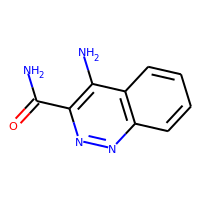
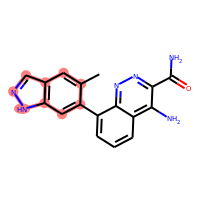
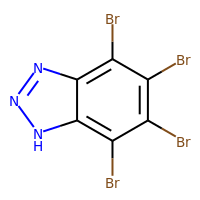
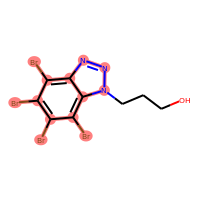

In [29]:
# Note, figure with more annotations will be found below
unfragmented_as_substructure_in_original_ligands_unique.head(2)

**Are these substructures fragment-like?**

'Fragment-like' definition taken from https://europepmc.org/article/med/14554012

In [30]:
fragment_likeness = [
    get_ro3_from_mol(row.fragment) 
    for index, row 
    in unfragmented_as_substructure_in_original_ligands_unique.iterrows()
]
fragment_likeness = pd.concat(fragment_likeness, axis=1).transpose()
fragment_likeness.head()

# Number of fulfilled rules (all rules)
fragment_likeness['n_fulfilled_extended'] = fragment_likeness.apply(sum, axis=1)

# Number of fulfilled rules (only basic rules: mw, logp, hbd, hba)
fragment_likeness['n_fulfilled_basic'] = fragment_likeness.apply(lambda x: x.mw + x.logp + x.hba + x.hbd, axis=1)

fragment_likeness.head()

,mw,logp,hbd,hba,nrot,psa,n_fulfilled_extended,n_fulfilled_basic
0,1,1,1,0,1,0,4,3
1,0,0,1,1,1,1,4,2
2,1,1,1,1,1,1,6,4
3,1,1,1,1,1,1,6,4
4,1,1,1,1,1,1,6,4


In [31]:
print(f'Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): '
      f'{fragment_likeness.groupby("n_fulfilled_basic").size()[4] / fragment_likeness.shape[0]}'
)

Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): 0.5714285714285714


**Draw fragment matches**

Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"


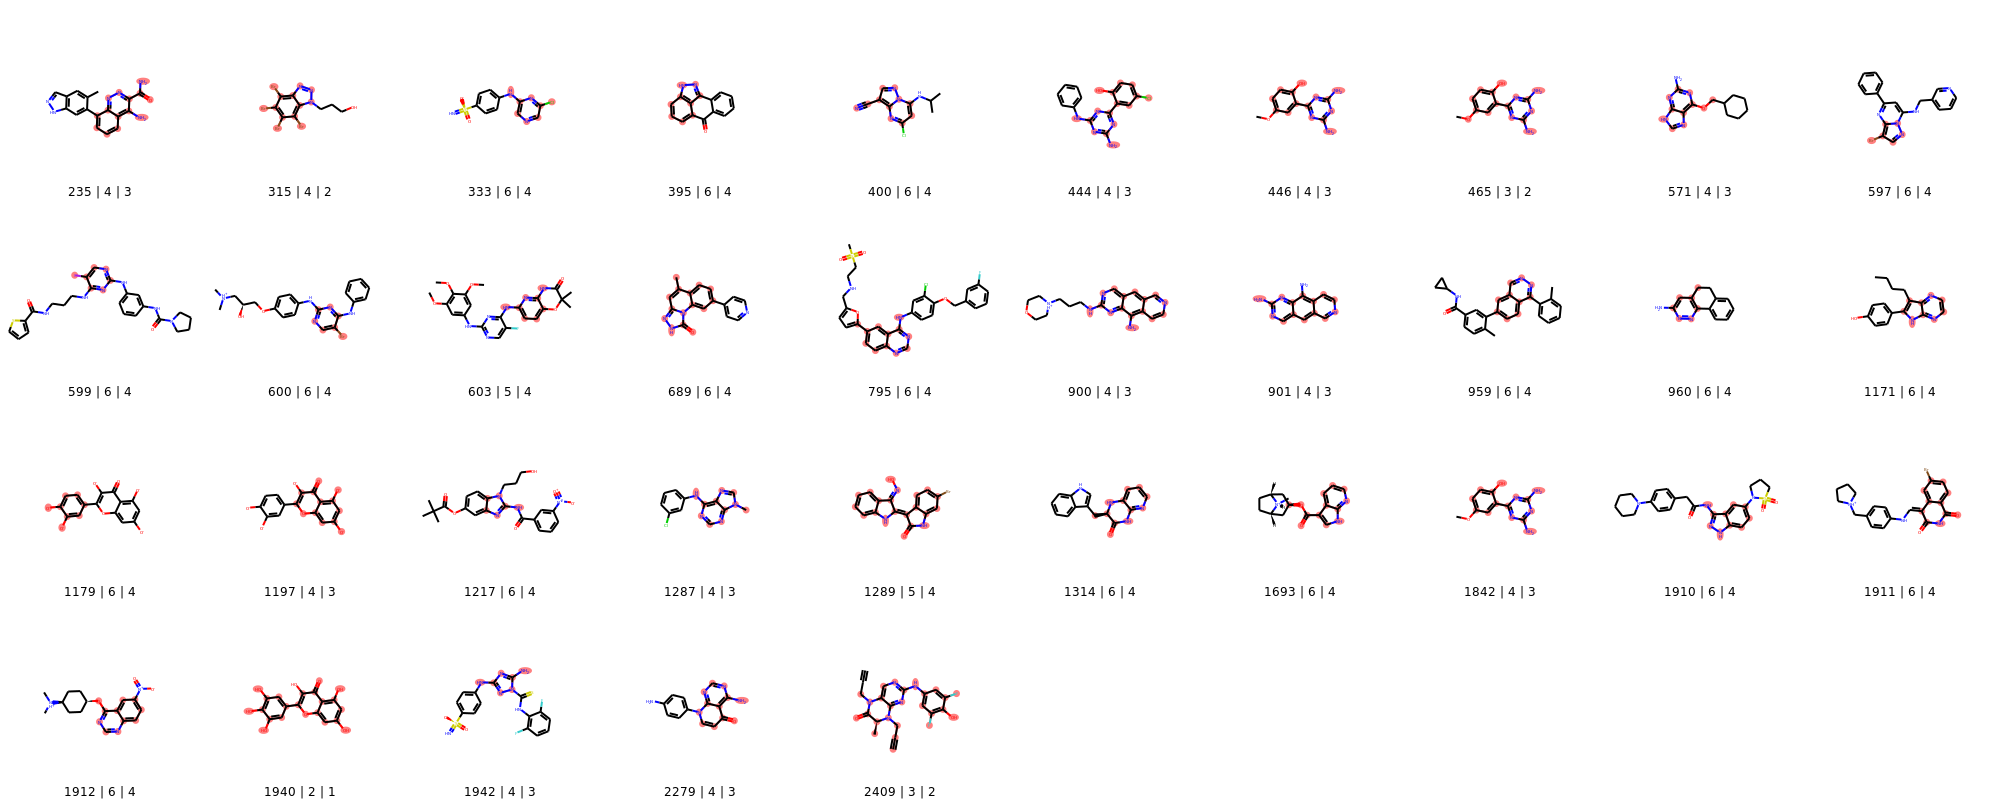

In [32]:
mols = list(unfragmented_as_substructure_in_original_ligands_unique.ligand)
highlight_atom_lists = list(unfragmented_as_substructure_in_original_ligands_unique.substructure)
legends = [
    f'{fragment_ix} | {n_fulfilled_ro3_extended} | {n_fulfilled_ro3_basic}' 
    for fragment_ix, n_fulfilled_ro3_extended, n_fulfilled_ro3_basic
    in zip(
        list(unfragmented_as_substructure_in_original_ligands_unique.fragment_ix), 
        list(fragment_likeness['n_fulfilled_extended']), 
        list(fragment_likeness['n_fulfilled_basic'])
    )
]

print(f'Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"')

Draw.MolsToGridImage(
    mols, 
    highlightAtomLists=highlight_atom_lists,
    legends=legends,
    molsPerRow=10
)

#### Examples for unfragmented ligands in paper

In [33]:
def draw_selected_fragments(selected_fragments, fragments, mols_per_row=3, max_mols=50):
    """
    Draw fragments selected by complex and ligand PDB ID.
    
    Parameters
    ----------
    selected_fragments : list of list of str
        List of fragments defined by complex and ligand PDB ID.
    fragments : pandas.DataFrame
        Fragments (including data like complex and ligand PDB ID, chain ID, and alternate model).
    mols_per_row : 
        Number of molecules per row.
    max_mols : int
        Number of molecules displayed.
        
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of selected fragments.
    """

    # Create DataFrame
    selected_fragments = pd.DataFrame(
        selected_fragments, 
        columns=['complex_pdb', 'ligand_pdb']
    )

    # Merge selected fragments with full fragment table in order to get full details on selected fragments
    selected_fragments = pd.merge(
        selected_fragments, 
        fragments, 
        left_on=['complex_pdb', 'ligand_pdb'],
        right_on=['complex_pdb', 'ligand_pdb'],
        how='left'
    )

    # Draw selected fragments
    image = draw_fragments(selected_fragments, mols_per_row, max_mols)

    return image

**Creates Figure S1.B-D in supporting information**

In [34]:
unfragmented_ligands_paper_b = [
    ['6q3b', 'PYZ'], 
    ['6q3c', 'BYZ'], 
    ['6q48', 'HHQ'],
    ['6q4a', 'HGW'],
    ['6q4b', 'HHN'], 
    ['6q4c', 'HH8'],
    ['6q4e', 'HH5'],
    ['6q4f', '26D']
]
unfragmented_ligands_paper_c = [
    ['3q9y', 'TXQ'],
    ['5j1w', '6FB'],
    ['2o63', 'MYC']
]
unfragmented_ligands_paper_d = [
    ['4fst', 'HK4'],
    ['3fyj', 'B97'],
    ['6cfm', 'EA7']
]

**(B1-B8) Fragment-like ligands**

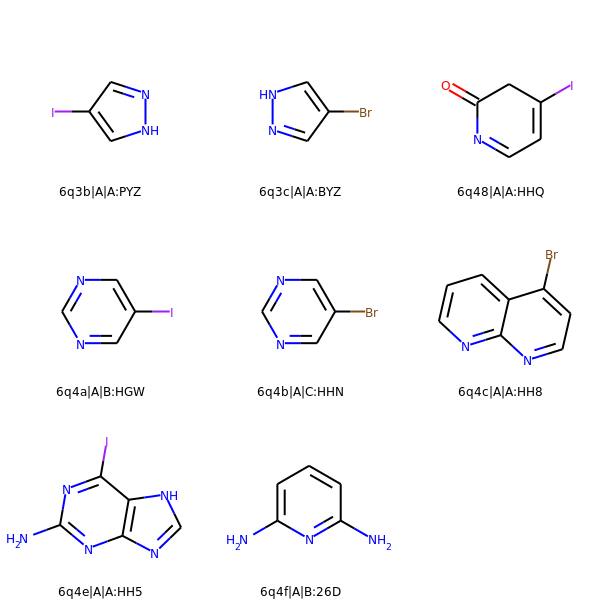

In [35]:
image_unfragmented_paper_b = draw_selected_fragments(
    unfragmented_ligands_paper_b, 
    unfragmented_ligands
)
image_unfragmented_paper_b.save(f'figures/extreme_subpockets_one_paper_b.png')
image_unfragmented_paper_b

**(C1-C3) Rigid/many fused rings containing ligands**

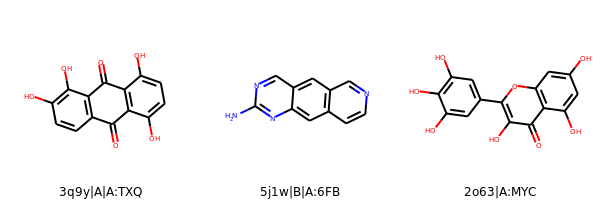

In [36]:
image_unfragmented_paper_c = draw_selected_fragments(
    unfragmented_ligands_paper_c, 
    unfragmented_ligands
)
image_unfragmented_paper_c.save(f'figures/extreme_subpockets_one_paper_c.png')
image_unfragmented_paper_c

**(D1-D3) Other larger unfragmented ligands**

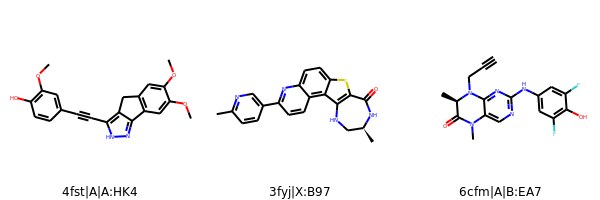

In [37]:
image_unfragmented_paper_d = draw_selected_fragments(
    unfragmented_ligands_paper_d, 
    unfragmented_ligands
)
image_unfragmented_paper_d.save(f'figures/extreme_subpockets_one_paper_d.png')
image_unfragmented_paper_d

## 4. Subpocket connectivity across subpockets

What subpocket connections do we see how often (connection as in a connection between 2 subpockets)? 

Respective information is stored in 'connections' column of `connections_by_fragment` (for all fragments in all subpockets except pool X).

### Connections per fragment

For each fragment, list all neighboring subpockets (`connections`), e.g. `[FP, SE]`, and all connections between the fragment's subpocket and its neighboring subpockets (`connections_name`), e.g. `[AP=FP, AP=SE]`, respectively.

In [38]:
connections_by_fragment = get_connections_by_fragment(fragment_library_concat)
print(connections_by_fragment.shape)

(7486, 7)


Look at fragments for a few example ligands (special cases): 
- `5te0` (with a fragment in pool X)
- `5ew9` (with two fragments occupying the same subpocket, connected to the same subpocket)
- `4yjq` (with two fragments occupying the same subpocket, connected to two different subpockets)

In [39]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5te0']

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
1,AAK1,5te0,XIN,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, GA]","[AP=SE, AP=GA]",AP
1,AAK1,5te0,XIN,SE SE SE SE SE SE SE SE SE SE SE SE SE SE SE S...,"[X, AP]","[SE=X, AP=SE]",SE
0,AAK1,5te0,XIN,GA GA GA GA GA GA GA AP,[AP],[AP=GA],GA
0,AAK1,5te0,XIN,X-SE X-SE X-SE X-SE X-SE X-SE X-SE X-SE X-SE X...,[SE],[SE=X],X


In [40]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5ew9']

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
142,AurA,5ew9,5VC,AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE],AP
119,AurA,5ew9,5VC,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP F...,"[SE, SE]","[FP=SE, FP=SE]",FP
115,AurA,5ew9,5VC,SE SE SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
116,AurA,5ew9,5VC,SE SE SE FP,[FP],[FP=SE],SE


In [41]:
connections_by_fragment[connections_by_fragment.complex_pdb == '4yjq']

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
2221,SYK,4yjq,4DK,AP AP AP AP AP AP AP AP AP AP GA SE,"[GA, SE]","[AP=GA, AP=SE]",AP
1654,SYK,4yjq,4DK,FP FP FP FP FP FP FP FP FP FP SE,[SE],[FP=SE],FP
1655,SYK,4yjq,4DK,FP FP FP FP FP FP FP FP FP FP FP GA,[GA],[FP=GA],FP
1354,SYK,4yjq,4DK,SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
824,SYK,4yjq,4DK,GA GA GA GA GA GA GA GA GA GA GA GA GA GA GA F...,"[FP, AP]","[FP=GA, AP=GA]",GA


### Connections per ligand

Pool fragment connections by ligand: Each ligand will have each connection listed twice. For example, in a ligand with the two fragments in `AP` and `SE`, the two connecting fragments `AP` and `SE` will both be associated by the connections `AP=SE`. After pooling fragment connections by ligand, the ligand will have listed the connections `['AP=SE', 'AP=SE']`.

In [42]:
connections_by_ligand = connections_by_fragment.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
)['connections_name'].sum()
connections_by_ligand

kinase  complex_pdb  ligand_pdb
AAK1    5l4q         LKB                         [AP=FP, AP=SE, AP=FP, AP=SE]
        5te0         XIN             [AP=SE, AP=GA, SE=X, AP=SE, AP=GA, SE=X]
ABL1    2f4j         VX6           [AP=SE, FP=GA, FP=SE, AP=SE, FP=SE, FP=GA]
        2gqg         1N1                         [AP=GA, AP=SE, AP=SE, AP=GA]
        2v7a         627                         [AP=SE, AP=FP, AP=FP, AP=SE]
                                                      ...                    
p70S6K  4l42         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l43         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l44         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l45         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l46         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
Name: connections_name, Length: 2553, dtype: object

**Sanity check**: This also means, that all fragment connections for each ligand must have an even count. Check:

In [43]:
connections_by_ligand_count = connections_by_ligand.apply(lambda x: Counter(x))
connections_by_ligand_count.head()

kinase  complex_pdb  ligand_pdb
AAK1    5l4q         LKB                       {'AP=FP': 2, 'AP=SE': 2}
        5te0         XIN            {'AP=SE': 2, 'AP=GA': 2, 'SE=X': 2}
ABL1    2f4j         VX6           {'AP=SE': 2, 'FP=GA': 2, 'FP=SE': 2}
        2gqg         1N1                       {'AP=GA': 2, 'AP=SE': 2}
        2v7a         627                       {'AP=SE': 2, 'AP=FP': 2}
Name: connections_name, dtype: object

In [44]:
# Are there any ligands that have an odd count for a connection? (That would point to a problem in the data.)
connections_by_ligand_count[
    ~connections_by_ligand_count.apply(
        lambda x: all([i%2 == 0 for i in list(x.values())])
    )
]

Series([], Name: connections_name, dtype: object)

Good, all ligands show an even count for each connection. Continue.

### Connection frequencies

How often is a certain connection (e.g. `AP=FP`) across all ligands? 

For this analysis, each connection is only considered once per ligand (even if a ligand has multiple e.g. `AP=FP` connections), hence only the presence or absence is considered per ligand.

In [45]:
# Get connection count across ligands (count each connection per ligand only once)
connections_across_ligands_count = pd.Series(Counter(connections_by_ligand_count.apply(list).sum()))
connections_across_ligands_count.name = 'count'

# Get connection frequency (100% = all ligands)
connections_across_ligands_frequency = connections_across_ligands_count.apply(lambda x: round((x / connections_by_ligand_count.shape[0] * 100), 1))
connections_across_ligands_frequency.name = 'frequency'

# Concatenate count and frequency data to DataFrame
connections_across_ligands = pd.concat([connections_across_ligands_count, connections_across_ligands_frequency], axis=1)
connections_across_ligands.sort_values(by='count', ascending=False)

,count,frequency
AP=FP,1569,61.5
AP=SE,1502,58.8
AP=GA,920,36.0
FP=GA,198,7.8
FP=SE,196,7.7
FP=X,131,5.1
SE=X,130,5.1
B1=GA,94,3.7
B2=GA,84,3.3
B1=B2,10,0.4


## 5. Fragments occurrence per subpocket

### Deduplicated fragments (per subpocket)

Deduplicate fragmentes per subpocket based on their SMILES.

In [46]:
# Collect all fragments and deduplicated version of them
n_fragments_per_subpocket = [len(fragments) for subpocket, fragments in fragment_library.items()]
n_fragments_per_subpocket_deduplicated = [len(fragments.drop_duplicates('smiles')) for subpocket, fragments in fragment_library.items()]

In [47]:
# Get fragments numbers per subpocket
stats_n_fragments = pd.DataFrame(
    {
        'n_fragments': n_fragments_per_subpocket,
        'n_fragments_deduplicated': n_fragments_per_subpocket_deduplicated,
        'freq_duplicates': [(i-j) / i * 100 for i, j in zip(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)]
    },
    index=fragment_library.keys()
)
stats_n_fragments

,n_fragments,n_fragments_deduplicated,freq_duplicates
AP,2561,1115,56.462319
FP,1866,864,53.697749
SE,1560,607,61.089744
GA,1024,306,70.117188
B1,98,42,57.142857
B2,92,43,53.260870
X,285,110,61.403509


In [48]:
print(f'Mean duplicates frequency across subpockets: {stats_n_fragments.freq_duplicates.mean()}')

Mean duplicates frequency across subpockets: 59.02489073891017


**Distribution of fragments across the different subpockets**

In [49]:
pd.DataFrame(
    {
        'freq_fragments': [i / sum(n_fragments_per_subpocket[:-1]) * 100 for i in n_fragments_per_subpocket[:-1]],
        'freq_fragments_deduplicated': [i / sum(n_fragments_per_subpocket_deduplicated[:-1]) * 100 for i in n_fragments_per_subpocket_deduplicated[:-1]]
    },
    index=list(fragment_library.keys())[:-1]
)

,freq_fragments,freq_fragments_deduplicated
AP,35.564505,37.453813
FP,25.913068,29.022506
SE,21.663658,20.389654
GA,14.220247,10.278804
B1,1.360922,1.410816
B2,1.277600,1.444407


In [50]:
print(f'Number of fragments (wo X): {sum(n_fragments_per_subpocket[:-1])}')
print(f'Number of deduplicated fragments (wo X): {sum(n_fragments_per_subpocket_deduplicated[:-1])}')

Number of fragments (wo X): 7201
Number of deduplicated fragments (wo X): 2977


**Creates Figure 3.B in manuscript**

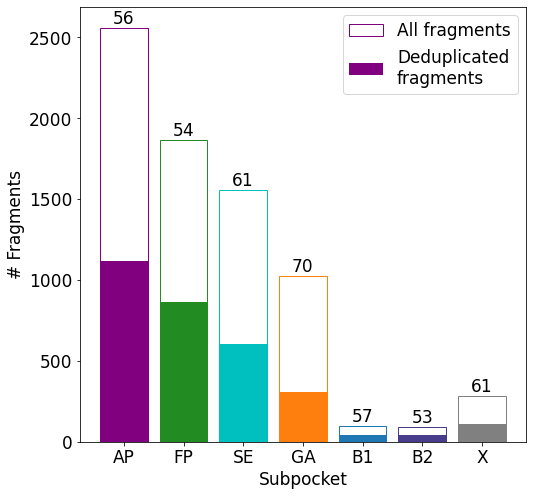

In [51]:
plot_n_fragments_per_subpocket(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)

### Ligands with multiple fragments per subpocket

1. How many ligands have fragments occupying the same subpocket multiple times?
2. How many ligands have fragments occupying the same subpocket *and thereby connecting to the same neighbor subpocket*?

Ligands from question 2 are a subset of ligands from question 1. Example `5ew9` covers both questions:

In [52]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5ew9']

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
142,AurA,5ew9,5VC,AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE],AP
119,AurA,5ew9,5VC,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP F...,"[SE, SE]","[FP=SE, FP=SE]",FP
115,AurA,5ew9,5VC,SE SE SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
116,AurA,5ew9,5VC,SE SE SE FP,[FP],[FP=SE],SE


Perform the following calculations without pool X: Everything that cannot be assigned to a subpocket is dumped in pool X. Therefore, connections to pool X do not necessarily represent real connections.

In [53]:
connections_by_fragment_wo_x = connections_by_fragment[connections_by_fragment.subpocket != 'X'].copy()

**1. How many ligands have fragments occupying the same subpocket multiple times?**

In [54]:
# Count number of fragments per subpocket and ligand (exclude pool X)
n_fragments_per_subpocket_and_ligand = connections_by_fragment_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).size() 
n_fragments_per_subpocket_and_ligand.name = 'counts'

In [55]:
print(f'Number of ligands have fragments occupying the same subpocket multiple times:')
n_fragments_per_subpocket_and_ligand[n_fragments_per_subpocket_and_ligand > 1].shape[0]

Number of ligands have fragments occupying the same subpocket multiple times:


126

More detail: Check per subpocket, how often it is occupied once, twice, or more times across all ligands:

In [56]:
n_fragments_per_subpocket_and_ligand.reset_index().groupby(['subpocket', 'counts']).size()

subpocket  counts
AP         1         2545
           2            8
B1         1           96
           2            1
B2         1           92
FP         1         1675
           2           94
           3            1
GA         1         1020
           2            2
SE         1         1520
           2           20
dtype: int64

Get that ligand that occupies a subpocket three times...

In [57]:
n_fragments_per_subpocket_and_ligand[n_fragments_per_subpocket_and_ligand == 3]

kinase  complex_pdb  ligand_pdb  subpocket
PLK1    2yac         937         FP           3
Name: counts, dtype: int64

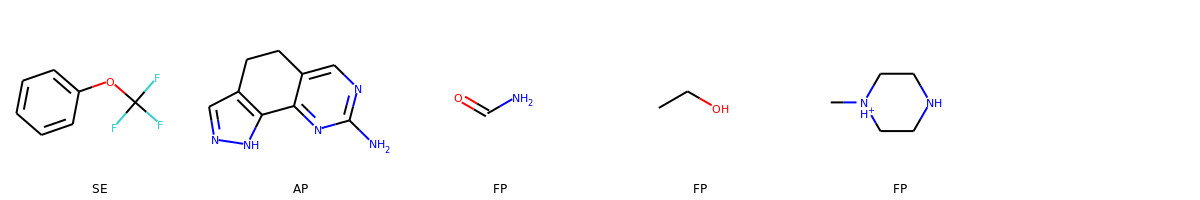

In [58]:
draw_fragmented_ligand(fragment_library, '2yac', '937')

Check out complex structure in KLIFS: https://klifs.vu-compmedchem.nl/details.php?structure_id=4957

**How many ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket?**

In [59]:
# Fragments that have multipe connections to the same subpocket
fragments_multiple_connections_to_same_subpocket = connections_by_fragment_wo_x[
    connections_by_fragment_wo_x.apply(
        lambda x: len(x.connections) != len(set(x.connections)),
        axis=1
    )
]

In [60]:
print(f'Number of ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket:')
fragments_multiple_connections_to_same_subpocket.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

Number of ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket:


74

## 6. Fragment properties per subpocket

### Duplicates

Discussed in *8. Fragment promiscuity*.

### Physicochemical properties

Get descriptors for fragments per subpocket (deduplicated per subpocket):

In [61]:
descriptors = get_descriptors_by_fragments(fragment_library)

In [62]:
descriptors.groupby('subpocket').median()

,# HBD,# HBA,LogP,# Heavy atoms
subpocket,,,,
AP,1.0,3.0,1.20420,12.0
B1,1.0,1.5,1.15670,7.5
B2,0.0,1.0,1.27960,9.0
FP,1.0,2.0,0.72930,10.0
GA,1.0,1.0,1.40790,9.0
SE,1.0,2.0,0.98540,11.0
X,1.0,1.0,0.43055,7.0


**Creates Figure 5.A in manuscript**

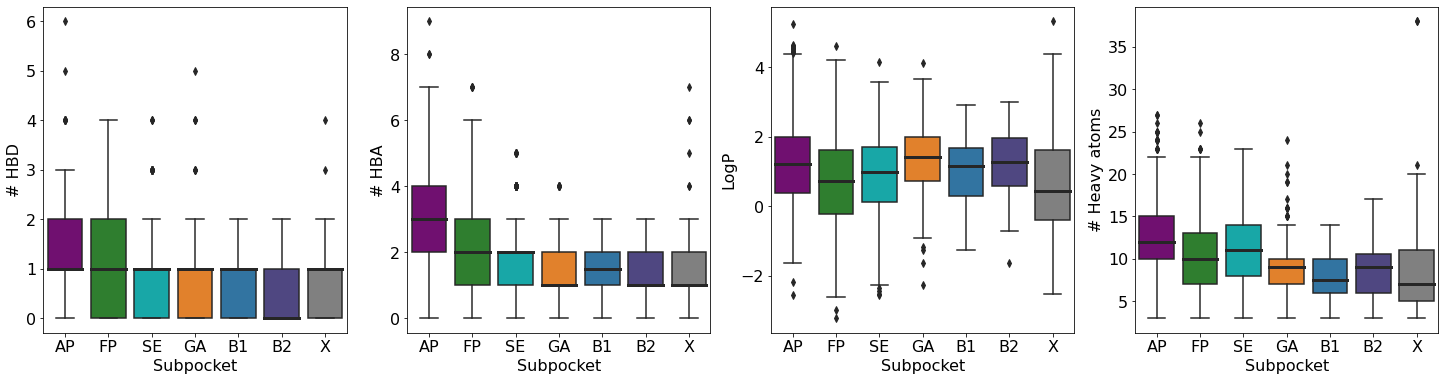

In [63]:
plot_fragment_descriptors(descriptors)

##### Some more details on the descriptor values per subpocket

In [64]:
descriptors.groupby('subpocket')['# HBD'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,1.286996,0.880754,0.0,1.0,1.0,2.0,6.0
B1,42.0,0.595238,0.543679,0.0,0.0,1.0,1.0,2.0
B2,43.0,0.534884,0.701998,0.0,0.0,0.0,1.0,2.0
FP,864.0,1.144676,0.888262,0.0,0.0,1.0,2.0,4.0
GA,306.0,0.820261,0.835904,0.0,0.0,1.0,1.0,5.0
SE,607.0,0.876442,0.812173,0.0,0.0,1.0,1.0,4.0
X,110.0,0.772727,0.725159,0.0,0.0,1.0,1.0,4.0


In [65]:
descriptors.groupby('subpocket')['# HBA'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,3.081614,1.446091,0.0,2.0,3.0,4.0,9.0
B1,42.0,1.380952,0.763573,0.0,1.0,1.5,2.0,3.0
B2,43.0,1.348837,0.783269,0.0,1.0,1.0,2.0,3.0
FP,864.0,1.958333,1.270259,0.0,1.0,2.0,3.0,7.0
GA,306.0,1.500000,0.927715,0.0,1.0,1.0,2.0,4.0
SE,607.0,1.751236,1.060416,0.0,1.0,2.0,2.0,5.0
X,110.0,1.454545,1.324687,0.0,1.0,1.0,2.0,7.0


In [66]:
descriptors.groupby('subpocket')['LogP'].describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
X,110.0,0.637483,1.481660,-2.5223,-0.404825,0.43055,1.616925,5.30610
FP,864.0,0.678346,1.315180,-3.2074,-0.216122,0.72930,1.611725,4.60112
SE,607.0,0.878808,1.190076,-2.5398,0.113200,0.98540,1.703800,4.13230
B1,42.0,1.073996,1.028205,-1.2485,0.294535,1.15670,1.683875,2.90130
AP,1115.0,1.255060,1.169443,-2.5461,0.392100,1.20420,1.990235,5.23640
B2,43.0,1.234849,0.926753,-1.6339,0.593900,1.27960,1.947360,3.00630
GA,306.0,1.341928,0.994495,-2.2714,0.730022,1.40790,1.991490,4.11040


In [67]:
descriptors.groupby('subpocket')['# Heavy atoms'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,12.596413,4.004529,3.0,10.0,12.0,15.0,27.0
B1,42.0,8.071429,2.982820,3.0,6.0,7.5,10.0,14.0
B2,43.0,8.813953,3.560737,3.0,6.0,9.0,10.5,17.0
FP,864.0,10.539352,4.279984,3.0,7.0,10.0,13.0,26.0
GA,306.0,8.908497,3.182657,3.0,7.0,9.0,10.0,24.0
SE,607.0,10.859967,4.072588,3.0,8.0,11.0,14.0,23.0
X,110.0,8.736364,5.885260,3.0,5.0,7.0,11.0,38.0


## 7. Fragment similarity per subpockets

1. Group and deduplicate all fragments by subpocket.
2. Calculate similarities for all pairwise fragment combinations within subpockets.

In [68]:
similarities_per_subpocket = get_fragment_similarity_per_subpocket(fragment_library_concat)
similarities_per_subpocket.head()

,similarity,subpocket
0,0.104987,AP
1,0.108247,AP
2,0.059072,AP
3,0.198225,AP
4,0.170306,AP


**Creates Figure 5.B in manuscript**

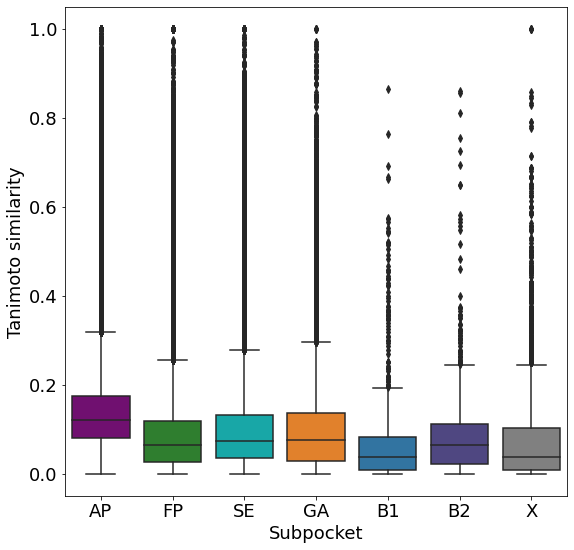

In [69]:
plot_fragment_similarity(similarities_per_subpocket, 'Subpocket')

In [70]:
similarities_per_subpocket.groupby('subpocket', sort=False).mean()

,similarity
subpocket,
AP,0.139185
FP,0.089188
SE,0.102719
GA,0.104821
B1,0.074256
B2,0.088506
X,0.077704


In [71]:
{key: len(value) for key, value in fragment_library.items()}

{'AP': 2561, 'FP': 1866, 'SE': 1560, 'GA': 1024, 'B1': 98, 'B2': 92, 'X': 285}

## 8. Fragment promiscuity

### Fragment similarity between and across kinase groups

Are fragments more similar within kinase groups than across kinase groups?

1. Group and deduplicate all fragments by kinase group and subpocket (excluding pool X).
2. Calculate similarities for all pairwise fragment combinations within kinase groups and subpockets (excluding X).
4. Calculate total distribution across all kinase groups (i.e. get all similarities by kinase groups and subpockets for the new kinase group 'Total').

In [72]:
similarities_per_kinase_group = get_fragment_similarity_per_kinase_group(fragment_library_concat_wo_x)
similarities_per_kinase_group.head()

,similarity,group,subpocket
0,0.530864,AGC,AP
1,0.527607,AGC,AP
2,0.464865,AGC,AP
3,0.643411,AGC,AP
4,0.166065,AGC,AP


In [73]:
similarities_per_kinase_group.groupby('group').size()

group
AGC        7666
CAMK      53287
CK1         986
CMGC     148712
Other     22433
STE        5844
TK       135443
TKL       10476
Total    384847
dtype: int64

**Creates Figure 5.C in manuscript**

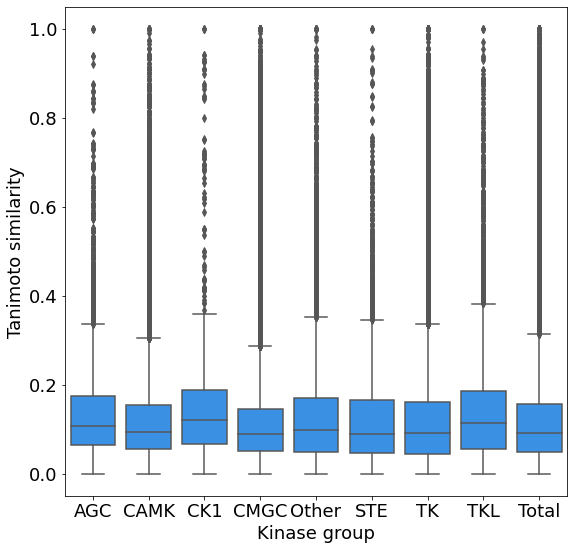

In [74]:
plot_fragment_similarity(similarities_per_kinase_group, 'Kinase group')

In [75]:
similarities_per_kinase_group.groupby('group', sort=False).mean()

,similarity
group,
AGC,0.134660
CAMK,0.119845
CK1,0.160031
CMGC,0.111484
Other,0.126572
STE,0.123428
TK,0.119414
TKL,0.137443
Total,0.117786


### Singletons vs. fragments with duplicates in subpocket pool

#### Term definitions

Let's define a few terms first:

* **Singletons**: Fragments' SMILES that appear only once in the dataset (subpocket pool)
* **Fragments with duplicates**: Fragments' SMILES that appear multiple times in the dataset (subpocket pool), i.e. they have duplicates.
* **Deduplicated fragments**: After deduplication of the SMILES in a subpocket pool, each fragments' SMILES will appear only once in the dataset, regardless if it had duplicates before or not: 
  > Number of **deduplicate fragments** = Number of **singletons** (they have no copies) + Number of fragments that have multiple copies (**fragments with duplicates**)

#### Procedure

1. Group fragments by subpocket and their SMILES (groups represent deduplicated fragments).
2. Count how often each fragment's SMILES occurs in the dataset (subpocket pool).
3. Per fragment, save all kinases and kinase groups that it was co-crystallized with. 

In [76]:
fragments_by_subpocket_and_smiles = pd.concat(
    [
        fragment_library_concat.groupby(['subpocket', 'smiles']).size(),
        fragment_library_concat.groupby(['subpocket', 'smiles'])['kinase'].apply(list), 
        fragment_library_concat.groupby(['subpocket', 'smiles'])['group'].apply(list),
    ], 
    axis=1
)
fragments_by_subpocket_and_smiles.rename(columns={0: 'occurrence'}, inplace=True)
fragments_by_subpocket_and_smiles.head()

occurrence  \
subpocket smiles                                     
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br           2   
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br           4   
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br           2   
          Brc1ccc2[nH]ccc2c1                     1   
          Brc1ccc2occc2c1                        2   

                                                             kinase  \
subpocket smiles                                                      
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br               [CK2a1, CK2a1]   
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CDK2, CK2a1, CK2a2, CK2a2]   
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br               [CK2a1, CK2a1]   
          Brc1ccc2[nH]ccc2c1                                 [PIM1]   
          Brc1ccc2occc2c1                              [PIM1, PIM1]   

                                                           group  
subpocket smiles                                                  
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br              [CMGC, CMGC]  
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CMGC, CMGC, CMGC, CMGC]  
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br              [CMGC, CMGC]  
          Brc1ccc2[nH]ccc2c1                              [CAMK]  
          Brc1ccc2occc2c1                           [CAMK, CAMK]

#### Questions

Data in `fragments_by_subpocket_and_smiles` allows to track the following:

What is the ratio of singletons vs. fragments with duplicates with respect to deduplicated dataset?

1. How many deduplicated fragments are there (within each subpocket)?
2. How many fragments (within subpockets) are singletons?
3. How many fragments (within subpockets) have duplicates?

If fragments occur multiple times in a subpocket pool, do they have a tendency for specific kinases or kinase groups?

4. Based on the fragments with duplicates, how many bind to the same kinase?
5. Based on the fragments with duplicates, how many bind to different kinases?
6. Based on the fragments with duplicates binding to different kinases, how many bind to the same kinase group?
7. Based on the fragments with duplicates binding to different kinases, how many to different kinase groups?

**1. How many deduplicated fragments are there (within each subpocket)?**

In [77]:
fragments_deduplicated = fragments_by_subpocket_and_smiles
fragments_deduplicated.shape[0]

3087

**2. How many fragments (within subpockets) are singletons?**

In [78]:
fragments_singletons = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) == 1,
        axis=1
    )
]
fragments_singletons.shape[0]

2071

**3. How many fragments (within subpockets) are duplicates?**

In [79]:
fragments_duplicates = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) != 1,
        axis=1
    )
]
fragments_duplicates.shape[0]

1016

In [80]:
# Collect numbers of singletons vs. fragments with duplicates
fragment_occurrence = pd.DataFrame(
    {
        '# singletons': fragments_singletons.reset_index().groupby('subpocket').size(),
        '# fragments with duplicates': fragments_duplicates.reset_index().groupby('subpocket').size(),
        '# deduplicated fragments': fragments_deduplicated.reset_index().groupby('subpocket').size()
    }
)
fragment_occurrence['% singletons'] = fragment_occurrence['# singletons'] / fragment_occurrence['# deduplicated fragments'] * 100
fragment_occurrence

,# singletons,# fragments with duplicates,# deduplicated fragments,% singletons
subpocket,,,,
AP,762,353,1115,68.340807
B1,29,13,42,69.047619
B2,27,16,43,62.790698
FP,607,257,864,70.254630
GA,181,125,306,59.150327
SE,397,210,607,65.403624
X,68,42,110,61.818182


In [81]:
print(f"Average ratio of singletons across subpockets: {fragment_occurrence.drop('X')['% singletons'].mean()}")

Average ratio of singletons across subpockets: 65.8312841176914


**4. Based on the fragments with duplicates, how many bind to the same kinase?**

In [82]:
fragments_duplicates_same_kinase = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) == 1),
        axis=1
    )
]
fragments_duplicates_same_kinase.shape[0]

381

**5. Based on the fragments with duplicates, how many bind to different kinases?**

In [83]:
fragments_duplicates_different_kinases = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases.shape[0]

635

**6. Based on the fragments with duplicates binding to different kinases, how many bind to the same kinase group?**

In [84]:
fragments_duplicates_different_kinases_same_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) == 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_same_group.shape[0]

155

**7. Based on the fragments with duplicates to different kinases, how many to different kinase groups?**

In [85]:
fragments_duplicates_different_kinases_and_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_and_group.shape[0]

480

**Summarize numbers**

Note: The DataFrames shown below where created in steps 1-7 above.

In [86]:
stats = pd.DataFrame(
    [
        fragments_deduplicated.reset_index().groupby('subpocket').size(),
        fragments_singletons.reset_index().groupby('subpocket').size(),
        fragments_duplicates.reset_index().groupby('subpocket').size(),
        fragments_duplicates_same_kinase.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_same_group.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_and_group.reset_index().groupby('subpocket').size(),
    ],
    index=[
        'fragments_deduplicated',
        'fragments_singletons',
        'fragments_duplicates',
        'fragments_duplicates_same_kinase',
        'fragments_duplicates_different_kinases',
        'fragments_duplicates_different_kinases_same_group',
        'fragments_duplicates_different_kinases_and_group',
    ]
)
stats

subpocket,AP,B1,B2,FP,GA,SE,X
fragments_deduplicated,1115,42,43,864,306,607,110
fragments_singletons,762,29,27,607,181,397,68
fragments_duplicates,353,13,16,257,125,210,42
fragments_duplicates_same_kinase,149,6,8,95,39,72,12
fragments_duplicates_different_kinases,204,7,8,162,86,138,30
fragments_duplicates_different_kinases_same_group,51,4,2,44,25,24,5
fragments_duplicates_different_kinases_and_group,153,3,6,118,61,114,25


In [87]:
stats.transpose().sum()

fragments_deduplicated                               3087
fragments_singletons                                 2071
fragments_duplicates                                 1016
fragments_duplicates_same_kinase                      381
fragments_duplicates_different_kinases                635
fragments_duplicates_different_kinases_same_group     155
fragments_duplicates_different_kinases_and_group      480
dtype: int64

In [88]:
print(
    f'Ratio of singletons \n(with respect to deduplicated fragments):\n'
    f'{fragments_singletons.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind only to one kinase \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_same_kinase.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinases and kinase groups \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinase groups \n(with respect to fragments that bind to different kinases):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_duplicates_different_kinases.shape[0]}\n'
)

Ratio of singletons 
(with respect to deduplicated fragments):
0.6708778749595076

Ratio of duplicate fragments that bind only to one kinase 
(with respect to deduplicated fragments):
0.12342079689018465

Ratio of duplicate fragments that bind to different kinases and kinase groups 
(with respect to deduplicated fragments):
0.1554907677356657

Ratio of duplicate fragments that bind to different kinase groups 
(with respect to fragments that bind to different kinases):
0.7559055118110236



## 9. Miscellaneous

### Draw ligand and fragments for GitHub README figure

In [89]:
complex_pdb = '3w2s'
ligand_pdb = 'W2R'

,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
1039,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,9 9 9 9 9 9 9 9 9 9 9 9 5 5 na na,Nc1ncnc2cc[nH]c12,[23*]Nc1ncnc2ccn([46*])c12,AP
374,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,GA GA GA GA GA GA GA GA GA GA GA B1 AP,16 16 16 16 16 16 16 16 16 3 16 na na,Oc1ccccc1Cl,[24*]Oc1ccc([61*])cc1Cl,GA
47,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,B1 B1 B1 B1 B1 B1 B1 B1 B1 B1 GA B2,16 16 16 16 16 16 16 16 16 16 na na,c1ccccc1,[63*]c1cccc([70*])c1,B1
18,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B...,1 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15...,NC(=O)NC1CCCCC1,[22*]NC(=O)NC1CCCCC1,B2
737,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,8 8 8 8 8 8 4 4 4 4 4 4 3 3 3 na,CCOCCO,[60*]CCOCCO,FP

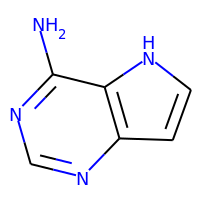
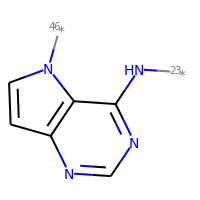
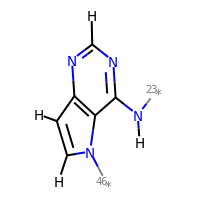
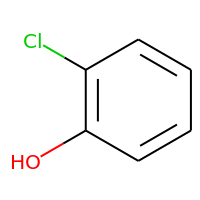
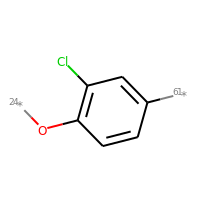
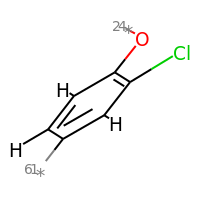
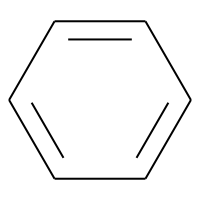
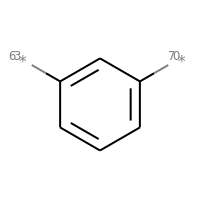
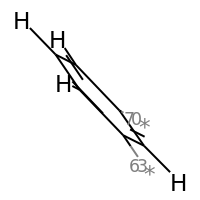
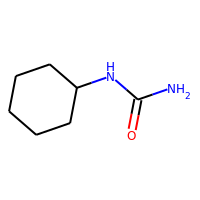
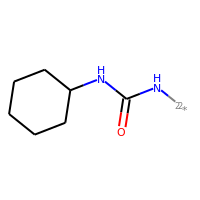
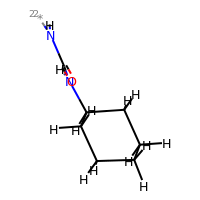
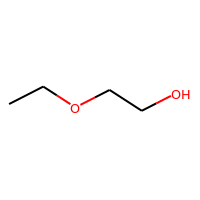
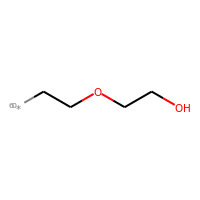
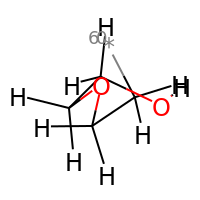

In [90]:
get_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb)

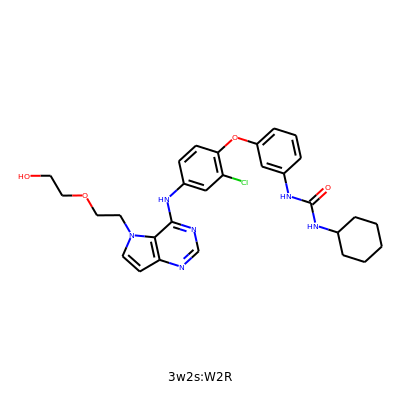

In [91]:
img = draw_ligands_from_pdb_ids(complex_pdb, ligand_pdb, sub_img_size=(400,400), mols_per_row=1)
img

In [92]:
img.save(f'figures/ligands_3w2s.png')

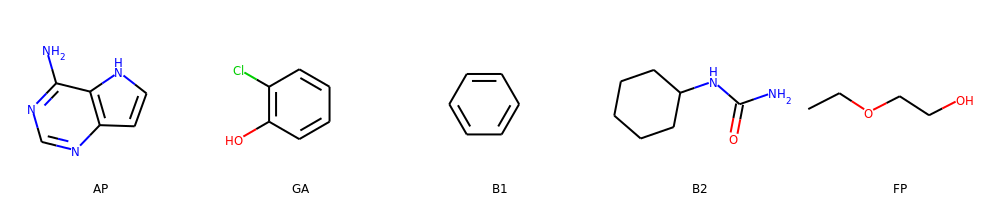

In [93]:
img = draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)
img

In [94]:
img.save(f'figures/fragments_3w2s_altA_chainA.png')

### Ligands occupying B1/B2 predominantly in aC-out/out-like conformations?

Goal: Compare ratio of aC-in/out/out-like ratio for back cleft binders (ligands with fragments in B1 and B2) against front cleft binders, in order to explain why we only have so little ligands reaching subpockets B1 and B2. 
To check if structures with ligands reaching B1 and B2 are enriched in the aC-out/out-like conformations. 

**KLIFS definitions for aC-in/out/out-like**: Distance between Ca atoms of D(xDFG.81) and E(aC.24)
* aC-in: 4-7.2 A
* aC-out: 9.3-14 A
* aC-out-like: distances in between

In [95]:
b1_or_b2_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' in x) or ('B2' in x))]
b1_and_b2_non_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' not in x) and ('B2' not in x))]

In [96]:
ac_conformations_stats = pd.concat(
    [
        original_ligands.groupby('ac_helix').size(),
        b1_and_b2_non_binders.groupby('ac_helix').size(),
        b1_or_b2_binders.groupby('ac_helix').size(),
    ],
    axis=1
)
ac_conformations_stats.rename(columns={0: 'all ligands', 1: 'front cleft binder', 2: 'back cleft binder'}, inplace=True)


ac_conformations_stats

,all ligands,front cleft binder,back cleft binder
in,1766,1722,44.0
na,2,2,NaN
out,543,461,82.0
out-like,242,189,53.0


In [97]:
ac_conformations_stats.sum()

all ligands           2553.0
front cleft binder    2374.0
back cleft binder      179.0
dtype: float64